In [15]:
#Guadalupe Maria Armenta Mendoza 
#R00259577

In [7]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import random

#loading the best models based on their accuracy and loss performance
cnn_model = load_model('best_cnn_model.keras') #CNN
vgg_model = load_model('VGG16_finetuned_stage2.keras') #tuned VGG16

#We need to  gather test filenames and sort by numeric ID
test_dir = 'data/test'
fnames = os.listdir(test_dir)
#keep only .jpg, sort by integer stem
fnames = sorted([f for f in fnames if f.lower().endswith('.jpg')],
                key=lambda x: int(os.path.splitext(x)[0]))

#Load & preprocess images for each model
#two arrays: one for CNN (128×128), one for VGG (224×224)
cnn_size = (128, 128)
vgg_size = (224, 224)

cnn_imgs = []
vgg_imgs = []
ids      = []

for fname in fnames:
    img_id = int(os.path.splitext(fname)[0])
    ids.append(img_id)
    
    #Load and preprocess for Custom CNN
    img = load_img(os.path.join(test_dir, fname), target_size=cnn_size)
    arr = img_to_array(img) / 255.0
    cnn_imgs.append(arr)
    
    #Load and preprocess for VGG16
    img224 = load_img(os.path.join(test_dir, fname), target_size=vgg_size)
    arr224 = img_to_array(img224) / 255.0
    vgg_imgs.append(arr224)

cnn_array = np.stack(cnn_imgs, axis=0)
vgg_array = np.stack(vgg_imgs, axis=0)

#Run predictions

#Model.predict returns probabilities-> threshold at 0.5
cnn_probs = cnn_model.predict(cnn_array, batch_size=32)
cnn_pred  = (cnn_probs.flatten() > 0.5).astype(int)

vgg_probs = vgg_model.predict(vgg_array, batch_size=32)
vgg_pred  = (vgg_probs.flatten() > 0.5).astype(int)

#Then, we assemple the outpues  into a DataFrame & save it 
df = pd.DataFrame({
    'id': ids,
    'cnn_pred': cnn_pred,
    'vgg_pred': vgg_pred,
})
#sorting by id just in case
df.sort_values('id', inplace=True)
df.to_csv('test_set_predictions.csv', index=False)

print("Saved predictions for", len(df), "test images to 'test_predictions.csv'")

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020D5F44B6A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step
Saved predictions for 100 test images to 'test_predictions.csv'


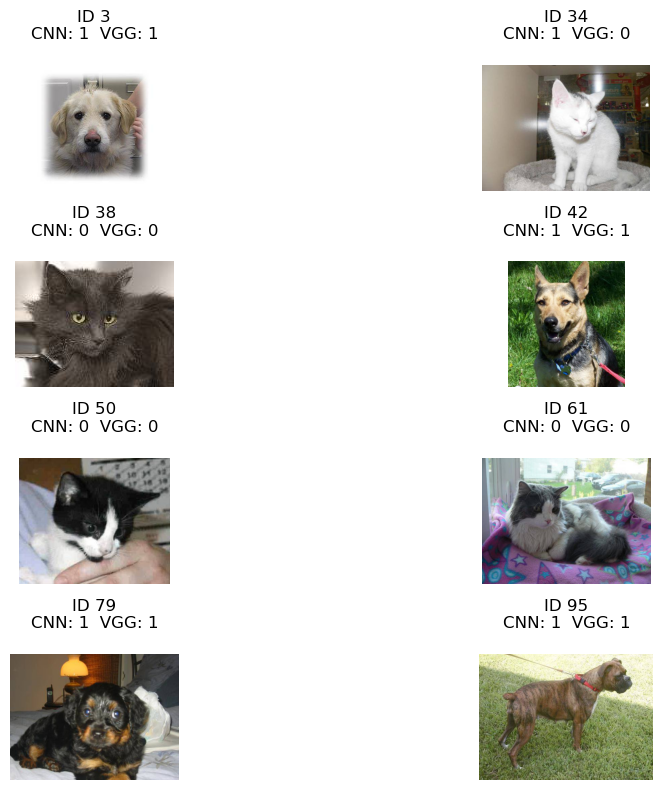

In [17]:
### to see the classifications visually 
#Loanding the predictions CSV we generated earlier
df = pd.read_csv('test_set_predictions.csv') #contains columns: id, cnn_pred, vgg_pred
random.seed(588)
#Randomly sample a few IDs to inspect
sample_ids = df['id'].sample(8).values
samples = df[df['id'].isin(sample_ids)]

#Plotting each image with its prediction
plt.figure(figsize=(12, 8))
for i, row in enumerate(samples.itertuples(), 1):
    img_path = f"data/test/{row.id}.jpg"
    img = load_img(img_path)
    plt.subplot(4, 2, i)
    plt.imshow(img)
    plt.title(
        f"ID {row.id}\n"
        f"CNN: {row.cnn_pred}  "
        f"VGG: {row.vgg_pred}\n")
    plt.axis('off')

plt.tight_layout()
plt.show()